In [1]:
import sys

!{sys.executable} -m pip install -U --pre "mxnet>=1.7.0b20200713, <2.0.0" -f https://sxjscience.github.io/KDD2020/


Looking in links: https://sxjscience.github.io/KDD2020/
     |████████████████████████████████| 55.0MB 57kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!{sys.executable} -m pip install autogluon

     |████████████████████████████████| 624kB 5.7MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 2.6MB 43.2MB/s 
     |████████████████████████████████| 112kB 43.3MB/s 
     |████████████████████████████████| 28.6MB 116kB/s 
     |████████████████████████████████| 215kB 41.6MB/s 
     |████████████████████████████████| 153kB 38.6MB/s 
     |████████████████████████████████| 819kB 43.3MB/s 
     |████████████████████████████████| 133kB 46.4MB/s 
     |████████████████████████████████| 66.3MB 42kB/s 
     |████████████████████████████████| 890kB 40.5MB/s 
     |████████████████████████████████| 1.8MB 37.9MB/s 
     |████████████████████████████████| 665kB 42.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 962kB 36.0MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 3.0MB 38.2MB/s 

In [3]:
!{sys.executable} -m pip install bokeh==2.0.1

     |████████████████████████████████| 8.6MB 5.2MB/s 
  Created wheel for bokeh: filename=bokeh-2.0.1-cp36-none-any.whl size=9080030 sha256=c7d0a350e325dd3428ba7dc7c3fffc8c76c42cadfbd11d7950a5cbc1d99de098
  Stored in directory: /root/.cache/pip/wheels/de/64/d0/e7f70919e19f57a6efceb65cc4edaa0449e707bcdb6e7e61ad
Successfully built bokeh
ERROR: panel 0.9.7 has requirement bokeh>=2.1, but you'll have bokeh 2.0.1 which is incompatible.
  Found existing installation: bokeh 2.1.1
    Uninstalling bokeh-2.1.1:
      Successfully uninstalled bokeh-2.1.1


AFTER RUN PRECEDING PIP INSTALLS (ETC), MUST RESTART RUNTIME (Runtime>>Restart Runtime)


In [1]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [2]:
###READ IN DATA
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('seaborn-poster')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving TemperatureOverTimeByStation.csv to TemperatureOverTimeByStation.csv


In [94]:
import io
data = pd.read_csv(io.BytesIO(uploaded['TemperatureOverTimeByStation.csv']))

In [95]:
data.shape

(33865, 19)

In [96]:
data.head()

,Unnamed: 0,Hourstart,Temp_4847,Temp_94889,Temp_94847,Temp_94815,Temp_14833,Temp_14836,Temp_94860,Temp_4888,Temp_14826,Temp_14840,Temp_14845,Temp_94898,Temp_94894,Temp_14817,Temp_14850,Temp_94849,Temp_14841
0,1,2017-01-01 01:00:00,28.0,19.9,27.0,23.0,23.0,26.1,27.0,28.4,28.0,30.0,30.0,30.9,25.0,22.1,27.0,28.9,25.0
1,2,2017-01-01 02:00:00,26.1,19.0,26.1,25.0,23.0,24.1,24.1,28.4,28.0,25.0,28.0,30.0,24.1,21.6,26.1,26.1,28.0
2,3,2017-01-01 03:00:00,25.0,18.0,23.0,21.0,24.1,23.0,26.1,26.6,25.0,26.1,26.1,28.0,25.0,20.1,26.1,25.0,28.0
3,4,2017-01-01 04:00:00,24.1,19.9,24.1,26.1,24.1,23.0,24.1,24.8,25.0,30.0,25.0,28.0,24.1,19.4,27.0,24.1,28.0
4,5,2017-01-01 05:00:00,23.0,16.0,24.1,25.0,24.1,23.0,26.1,24.8,25.0,30.9,25.0,27.0,24.1,23.0,28.0,24.1,27.0


In [97]:
data=data.drop(['Unnamed: 0'],axis=1)
#Drop column added during R save


In [98]:
sorted_zipped_lists=sorted(zip(data.isna().sum(),list(data))) #sorts zipped lists by first list, which is the # of NA values for a given column

In [99]:
sorted_column_names = [element for _, element in sorted_zipped_lists]
sorted_column_names.remove('Hourstart') #remove Hourstart from list, because we don't need to impute any missing values for this variable

In [120]:
Comparison_Frame = pd.DataFrame(sorted_zipped_lists)
Comparison_Frame.rename(columns={0:"missing_values",1:"Station"},inplace=True)
Comparison_Frame.drop(Comparison_Frame.index[0],inplace=True)
Comparison_Frame = Comparison_Frame[['Station','missing_values']]

In [68]:
time_limits = 1 * 60 # train various models for ~5 min

performances=[]
all_results=[]

#Loop through each weather station in 'sorted_column_names' (ascending in terms of the N of missing observations, so we leave the largest imputation for the most complete dataset)
#AND impute missing values, then move to next station
for LC in sorted_column_names:
    label_column = LC
    print(label_column)
    nomissings=data.dropna(subset=[label_column]) #drop rows with missing values for the given column
    train = nomissings.sample(frac=0.75, random_state=99)
    # you can't simply split 0.75 and 0.25 without overlapping
    # this code tries to find that train = 75% and test = 25%
    test = nomissings.loc[~nomissings.index.isin(train.index), :]

    #use R2 as evaluation metric
    predictor = task.fit(train_data=train, tuning_data=test,
                        label=label_column,
                        time_limits = time_limits,
                        eval_metric = "r2")

    #performance of best model (or ensemble)
    performance = predictor.evaluate(test)

    #append performance metric/info to 'performances' list
    performances.append(performance)

    #overall results (i.e. all different models)
    results = predictor.fit_summary()

    #append results table/info to 'all_results' list
    all_results.append(results)

    missers = data.loc[~data.index.isin(nomissings.index), :] 
    print(missers.shape)
    #from the *data* df, pull those rows that 
    #weren't included once we dropped rows that were missing values for the given column
    predicted_missingvalues = predictor.predict(missers)

    missers[label_column]=predicted_missingvalues #plug-in interpreted values, obtained from autogluon

    combined=nomissings.append(missers)
    #recombine missers with nonmissers, creating a more robust dataset to model downstream analyses

    data = combined #define 'new' dataframe (data) with imputed values included

No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_181906/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_181906/
AutoGluon Version:  0.0.14
Train Data Rows:    25396
Train Data Columns: 17
Tuning Data Rows:    8466
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -9.9, 50.1799, 19.74923)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12525.96 MB
	Train Data (Original)  Memory Usage: 9.62 MB (0.1% of available memory)
	Inferring data type of

Temp_94860


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.9s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.61 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 5.01s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9943678078025353
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.994368       1.112027  71.833229                0.000926           0.222941            1       True          3
1    ExtraTreesRegressorMSE   0.994366       0.605131  22.589295                0.605131          22.589295            0       True          2
2  RandomForestRegressorMSE   0.994051       0.505970  49.020992                0.505970          49.020992            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182037/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182037/
AutoGluon Version:  0.0.14
Train Data Rows:    25363
Train Data Columns: 17
Tuning Data Rows:    8454
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (96.1, -13.0, 51.9586, 19.63998)
	If 'regression' is not the correct problem_type, please manually specify th

Temp_94847


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.76s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.993476068019466
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.993476       1.111008  71.082256                0.000823           0.222511            1       True          3
1    ExtraTreesRegressorMSE   0.993476       0.605102  22.534062                0.605102          22.534062            0       True          2
2  RandomForestRegressorMSE   0.992996       0.505083  48.325683                0.505083          48.325683            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182207/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182207/
AutoGluon Version:  0.0.14
Train Data Rows:    25360
Train Data Columns: 17
Tuning Data Rows:    8453
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -11.0, 49.3537, 19.90164)
	If 'regression' is not the correct problem_type, please manually specify th

Temp_14845


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.79s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9925823670932309
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.992582       0.605276  22.016498                0.605276          22.016498            0       True          2
1   weighted_ensemble_k0_l1   0.992582       0.606062  22.238643                0.000786           0.222145            1       True          3
2  RandomForestRegressorMSE   0.991889       0.504824  47.117542                0.504824          47.117542            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182333/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182333/
AutoGluon Version:  0.0.14
Train Data Rows:    25357
Train Data Columns: 17
Tuning Data Rows:    8452
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (98.1, -24.0, 45.48159, 20.02738)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94849


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.8s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.86s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9840511887297283
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.984051       0.604821  23.039288                0.604821          23.039288            0       True          2
1   weighted_ensemble_k0_l1   0.984051       0.605792  23.274740                0.000971           0.235453            1       True          3
2  RandomForestRegressorMSE   0.983172       0.504843  50.011290                0.504843          50.011290            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182512/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182512/
AutoGluon Version:  0.0.14
Train Data Rows:    25356
Train Data Columns: 17
Tuning Data Rows:    8452
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (96.1, -27.9, 44.45413, 20.55891)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14841


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.69s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.981679211871811
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.981679       0.605179  23.224546                0.605179          23.224546            0       True          2
1   weighted_ensemble_k0_l1   0.981679       0.606092  23.440072                0.000913           0.215526            1       True          3
2  RandomForestRegressorMSE   0.980513       0.504811  50.813813                0.504811          50.813813            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182646/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182646/
AutoGluon Version:  0.0.14
Train Data Rows:    25354
Train Data Columns: 17
Tuning Data Rows:    8451
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -17.0, 51.19213, 19.87811)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94815


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.72s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.992478904647879
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.992479       0.605039  22.513915                0.605039          22.513915            0       True          2
1   weighted_ensemble_k0_l1   0.992479       0.606351  22.724955                0.001312           0.211040            1       True          3
2  RandomForestRegressorMSE   0.991973       0.504563  48.112589                0.504563          48.112589            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182813/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182813/
AutoGluon Version:  0.0.14
Train Data Rows:    25353
Train Data Columns: 17
Tuning Data Rows:    8451
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (97.0, -8.0, 47.97853, 19.66159)
	If 'regression' is not the correct problem_type, please manually specify th

Temp_14850


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.77s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9890222115862444
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.989022       0.605104  22.431064                0.605104          22.431064            0       True          2
1   weighted_ensemble_k0_l1   0.989022       0.605923  22.657697                0.000819           0.226633            1       True          3
2  RandomForestRegressorMSE   0.987987       0.504785  49.114099                0.504785          49.114099            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_182958/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_182958/
AutoGluon Version:  0.0.14
Train Data Rows:    25350
Train Data Columns: 17
Tuning Data Rows:    8450
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (97.0, -16.1, 49.83175, 19.94201)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14826


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.73s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9936808676819201
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.993681       1.110478  68.821152                0.000856           0.224338            1       True          3
1    ExtraTreesRegressorMSE   0.993668       0.604887  21.783407                0.604887          21.783407            0       True          2
2  RandomForestRegressorMSE   0.993239       0.504735  46.813407                0.504735          46.813407            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_183125/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_183125/
AutoGluon Version:  0.0.14
Train Data Rows:    25345
Train Data Columns: 17
Tuning Data Rows:    8448
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (95.0, -12.0, 50.39676, 18.95486)
	If 'regression' is not the correct problem_type, please manually specify the pr

Temp_14840


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.8s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.82s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9872123547714428
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.987212       1.110593  72.975330                0.000873           0.207978            1       True          3
1    ExtraTreesRegressorMSE   0.987161       0.605215  22.933740                0.605215          22.933740            0       True          2
2  RandomForestRegressorMSE   0.986676       0.504506  49.833612                0.504506          49.833612            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_183329/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_183329/
AutoGluon Version:  0.0.14
Train Data Rows:    25338
Train Data Columns: 17
Tuning Data Rows:    8446
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -13.5, 49.7669, 20.00766)
	If 'regression' is not the correct problem_type, please manually specify th

Temp_14836


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.7s ...
AutoGluon will gauge p

Predictive performance on given dataset: r2 = 0.9954081820097893
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.995408       1.111015  68.205595                0.000853           0.214508            1       True          3
1    ExtraTreesRegressorMSE   0.995406       0.604883  21.579060                0.604883          21.579060            0       True          2
2  RandomForestRegressorMSE   0.995200       0.505279  46.412027                0.505279          46.412027            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_183455/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_183455/
AutoGluon Version:  0.0.14
Train Data Rows:    25331
Train Data Columns: 17
Tuning Data Rows:    8444
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -16.0, 50.17034, 19.72644)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14833


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.68s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9937804128083434
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.993780       1.110558  68.707003                0.000881           0.223473            1       True          3
1    ExtraTreesRegressorMSE   0.993779       0.604568  21.680646                0.604568          21.680646            0       True          2
2  RandomForestRegressorMSE   0.993481       0.505109  46.802884                0.505109          46.802884            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_183620/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_183620/
AutoGluon Version:  0.0.14
Train Data Rows:    25326
Train Data Columns: 17
Tuning Data Rows:    8442
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -19.0, 50.21239, 19.75756)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_4847


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.8s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.84s ...
AutoGluon will gaug

Predictive performance on given dataset: r2 = 0.9925034832421615
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.992503       1.113391  70.333102                0.001032           0.214625            1       True          3
1    ExtraTreesRegressorMSE   0.992503       0.607558  22.190411                0.607558          22.190411            0       True          2
2  RandomForestRegressorMSE   0.992002       0.504801  47.928066                0.504801          47.928066            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_183817/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_183817/
AutoGluon Version:  0.0.14
Train Data Rows:    25313
Train Data Columns: 17
Tuning Data Rows:    8438
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (95.0, -22.8, 45.35193, 20.67177)
	If 'regression' is not the correct problem_type, please manually specify the pr

Temp_14817


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.74s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9896602076324863
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    ExtraTreesRegressorMSE   0.989660       0.604732  24.160009                0.604732          24.160009            0       True          2
1   weighted_ensemble_k0_l1   0.989660       0.605553  24.382941                0.000820           0.222931            1       True          3
2  RandomForestRegressorMSE   0.988809       0.504999  49.817320                0.504999          49.817320            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_184030/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_184030/
AutoGluon Version:  0.0.14
Train Data Rows:    25222
Train Data Columns: 17
Tuning Data Rows:    8408
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (94.5, -18.4, 48.59139, 19.24161)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_4888


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.57 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.75s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9842836425719577
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.984284       1.110822  72.341774                0.001411           0.221744            1       True          3
1    ExtraTreesRegressorMSE   0.984209       0.604792  23.112062                0.604792          23.112062            0       True          2
2  RandomForestRegressorMSE   0.983825       0.504619  49.007969                0.504619          49.007969            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_184201/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_184201/
AutoGluon Version:  0.0.14
Train Data Rows:    25168
Train Data Columns: 17
Tuning Data Rows:    8390
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.0, -18.0, 49.44284, 19.81979)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94889


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	5.0s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.56 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 5.11s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9903586118369039
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.990359       1.113338  72.749751                0.000764           0.208678            1       True          3
1    ExtraTreesRegressorMSE   0.990352       0.605183  22.414569                0.605183          22.414569            0       True          2
2  RandomForestRegressorMSE   0.989970       0.507392  50.126503                0.507392          50.126503            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_184332/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_184332/
AutoGluon Version:  0.0.14
Train Data Rows:    25037
Train Data Columns: 17
Tuning Data Rows:    8346
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -5.0, 48.12986, 18.20073)
	If 'regression' is not the correct problem_type, please manually specify th

Temp_94898


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.54 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.65s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9726735254108215
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.972674       1.111186  71.599538                0.000970           0.216718            1       True          3
1  RandomForestRegressorMSE   0.972610       0.504961  48.806944                0.504961          48.806944            0       True          1
2    ExtraTreesRegressorMSE   0.971157       0.605255  22.575876                0.605255          22.575876            0       True          2
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_184534/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20201202_184534/
AutoGluon Version:  0.0.14
Train Data Rows:    25022
Train Data Columns: 17
Tuning Data Rows:    8340
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (91.9, -10.0, 46.73924, 18.90105)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94894


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	4.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.54 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 4.81s ...
AutoGluon will gauge 

Predictive performance on given dataset: r2 = 0.9850783235040436
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.985078       1.111279  72.564308                0.001019           0.217317            1       True          3
1    ExtraTreesRegressorMSE   0.985074       0.605200  22.832329                0.605200          22.832329            0       True          2
2  RandomForestRegressorMSE   0.984382       0.505061  49.514662                0.505061          49.514662            0       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'XTModel', 'RFModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{}], 'GBM': [{}, {'extra_trees': True, 'AG_args': {'name_suffi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
data.isna().sum() # check that we have no more missing values

Hourstart     0
Temp_4847     0
Temp_94889    0
Temp_94847    0
Temp_94815    0
Temp_14833    0
Temp_14836    0
Temp_94860    0
Temp_4888     0
Temp_14826    0
Temp_14840    0
Temp_14845    0
Temp_94898    0
Temp_94894    0
Temp_14817    0
Temp_14850    0
Temp_94849    0
Temp_14841    0
dtype: int64

In [72]:
data.to_csv('Weather_imputed.csv') 
files.download("Weather_imputed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [121]:
Comparison_Frame['Rsq']=performances
Comparison_Frame

,Station,missing_values,Rsq
1,Temp_94860,3,0.994368
2,Temp_94847,48,0.993476
3,Temp_14845,52,0.992582
4,Temp_94849,56,0.984051
5,Temp_14841,57,0.981679
6,Temp_94815,60,0.992479
7,Temp_14850,61,0.989022
8,Temp_14826,65,0.993681
9,Temp_14840,72,0.987212
10,Temp_14836,81,0.995408


In [122]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b


best fit line:
y = 0.99 + -0.00x


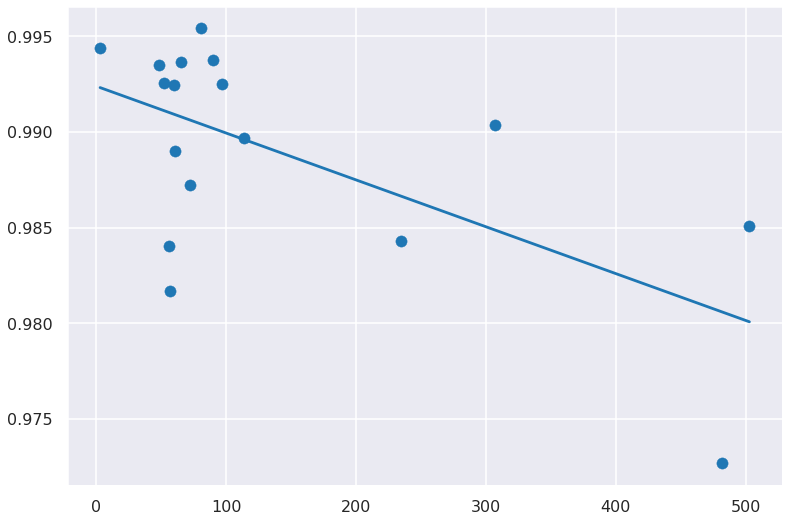

In [125]:
X = Comparison_Frame['missing_values']
Y = Comparison_Frame['Rsq']
a, b = best_fit(X,Y)

plt.scatter(X,Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit)

In [126]:
all_results

[{'feature_prune': False,
  'hyperparameter_tune': False,
  'hyperparameters_userspecified': {'default': {'CAT': [{}],
    'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
    'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
     {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
    'NN': [{}],
    'RF': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
      'criterion': 'mse'}],
    'XT': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
      'criterion': 'mse'}],
    'custom': [{'AG_args': {'disable_in_hpo': True,
       'model_type': 'GBM',
       'name_suffix': 'Custom'},
      'boosting_type': 'gbdt',
      'feature_fraction': 0.9,
      'learning_rate': 0.03,
      'min_data_in_leaf': 5,
      'num_boost_round': 10000,
      'num_leaves': 128,
      'num_threads': -1,
      'objective': 'regression',
      'seed_value': 0,
      'two_round': True,
      'verbose': -1}]}},
  'leaderboard'